In [2]:
import torch
import torch.nn.functional as F
import json, copy
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.cluster import KMeans
import scipy as sp
from scipy.cluster import hierarchy

In [4]:
from tqdm import tqdm

In [5]:
project_dir = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark"
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [34]:
result_path = '/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2'
detected_origin_path = f'{result_path}/checkpoints/knowledgetrans-motifs-predcls-exmp-3cluster/cat-base/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [28]:
def bbox_match(pred, gt):
    """Args:
        pred: [x0, y0, x1, y1]
        gt: same as above
    Returns: whether objects in gt and prediction are seen as same objects
    """
    xA = max(pred[0], gt[0])
    yA = max(pred[1], gt[1])
    xB = min(pred[2], gt[2])
    yB = min(pred[3], gt[3])
    intra_area = max(0, xB-xA+1)*max(0, yB-yA+1)
    pred_area = (pred[2]-pred[0]+1)*(pred[3]-pred[1]+1)
    gt_area = (gt[2]-gt[0]+1)*(gt[3]-gt[1]+1)
    iou = intra_area/float(pred_area+gt_area-intra_area)
    return iou>0.5

In [29]:
def find_match(pred_rels, gt_rels):
    """
    pred_rels, gt_rels: relation triplets
        sub_label: label of subject (String)
        obj_label: label of object  (String)
        sub_bbox:  bbox of subject  ([num_rel, 4])
        obj_bbox:  bbox of object   ([num_rel, 4])
        rel_label: relation label   (Int)
    """
    selected_pred_label = []
    selected_gt_label = []
    for pre in pred_rels:
        for gt in gt_rels:
            if pre["sub_label"]==gt["sub_label"] and pre["obj_label"]==gt["obj_label"] and bbox_match(pre["sub_bbox"],gt["sub_bbox"] ) and bbox_match(pre["obj_bbox"], gt["obj_bbox"]):
                selected_pred_label.append(pre["rel_label"])
                selected_gt_label.append(gt["rel_label"])
    return selected_pred_label, selected_gt_label

In [30]:
def extract_failure(pred_rels, gt_rels):
    """ See failed prediction samples
    Args:
        pred_rels: list[{sub_label: subject_label
                    obj_label: object label
                    sub_bbox: subject bbox
                    obj_bbox: object bbox
                    rel_label: relation label}]
        gt_rels: same as above
    """
    res = []
    for i, pred in enumerate(pred_rels):
        flag = False
        failed_gt = None
        # check every gt to see if a predicted predicte is failure or not
        for gt in gt_rels:
            if pred["sub_label"] == gt['sub_label'] and pred['obj_label'] == gt["obj_label"]:
                if bbox_match(pred['sub_bbox'], gt["sub_bbox"]) and bbox_match(pred["obj_bbox"], gt["obj_bbox"]):
                    if gt["rel_label"] == pred["rel_label"]:
                        flag = True
                        break
                    else:
                        failed_gt = gt
        if not flag and failed_gt:
            res.append({"prediction": pred, "groundtruth":failed_gt})
    return res  

In [31]:
pred2idx = vocab_file["predicate_to_idx"]

In [32]:
##### This is a code to see failed samples ######
result = {}
for i in tqdm(range(26446)):
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = idx2pred[str(tri[2])]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels')[:50]
    for j, k in zip(pred_rel_pair, pred_rel_label.tolist()):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = idx2pred[str(k)]
        pred_rels.append(tmp)
    failure = extract_failure(pred_rels, gt_rels)
    result[str(i)] = failure

100%|██████████| 26446/26446 [00:08<00:00, 3140.60it/s]


In [33]:
with open ("/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/analysis/kt-predcls-failure.json", "w") as f:
    json.dump(result, f, indent=2)

# confusion matrix

In [35]:
pred = []
gt = []
for i in tqdm(range(26446)):
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = tri[2]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels')[:50]
    for j, k in zip(pred_rel_pair, pred_rel_label.tolist()):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = k
        pred_rels.append(tmp)
    selected_pred_label, selected_gt_label = find_match(pred_rels, gt_rels)
    pred = pred+selected_pred_label
    gt = gt+selected_gt_label

100%|██████████| 26446/26446 [00:20<00:00, 1319.55it/s]


In [414]:
len(pred) == len(gt)

True

In [415]:
pred = np.array(pred)
gt = np.array(gt)
len(pred[pred==gt])/len(gt)

0.6092385381273393

In [416]:
cnt = {}
for g in gt:
    g_pred = idx2pred[str(g)]
    if g_pred not in cnt.keys():
        cnt[g_pred] = 1
    else:
        cnt[g_pred] += 1
print(cnt)

{'on': 72068, 'near': 6257, 'has': 27394, 'wearing': 25137, 'under': 1626, 'in front of': 1071, 'of': 21886, 'in': 12045, 'above': 2412, 'behind': 3846, 'sitting on': 2662, 'carrying': 740, 'walking on': 728, 'with': 5429, 'parked on': 383, 'wears': 2772, 'riding': 2355, 'on back of': 214, 'at': 666, 'holding': 5049, 'looking at': 310, 'using': 288, 'attached to': 905, 'standing on': 1460, 'hanging from': 352, 'eating': 396, 'laying on': 382, 'over': 400, 'part of': 158, 'across': 70, 'along': 122, 'for': 289, 'says': 10, 'to': 154, 'painted on': 102, 'growing on': 103, 'watching': 255, 'against': 55, 'flying in': 2, 'and': 168, 'between': 153, 'belonging to': 885, 'walking in': 79, 'lying on': 183, 'covered in': 172, 'covering': 247, 'mounted on': 208, 'from': 89, 'made of': 23, 'playing': 21}


In [417]:
val_mat = confusion_matrix(gt, pred)

In [418]:
mat = copy.deepcopy(val_mat).astype(float)
for i in range(mat.shape[0]):
    if np.sum(mat[i]):
        mat[i] = mat[i]/np.sum(mat[i])

In [419]:
labels = np.array([idx2pred[str(i)] for i in set(gt)], dtype=str)

<AxesSubplot:>

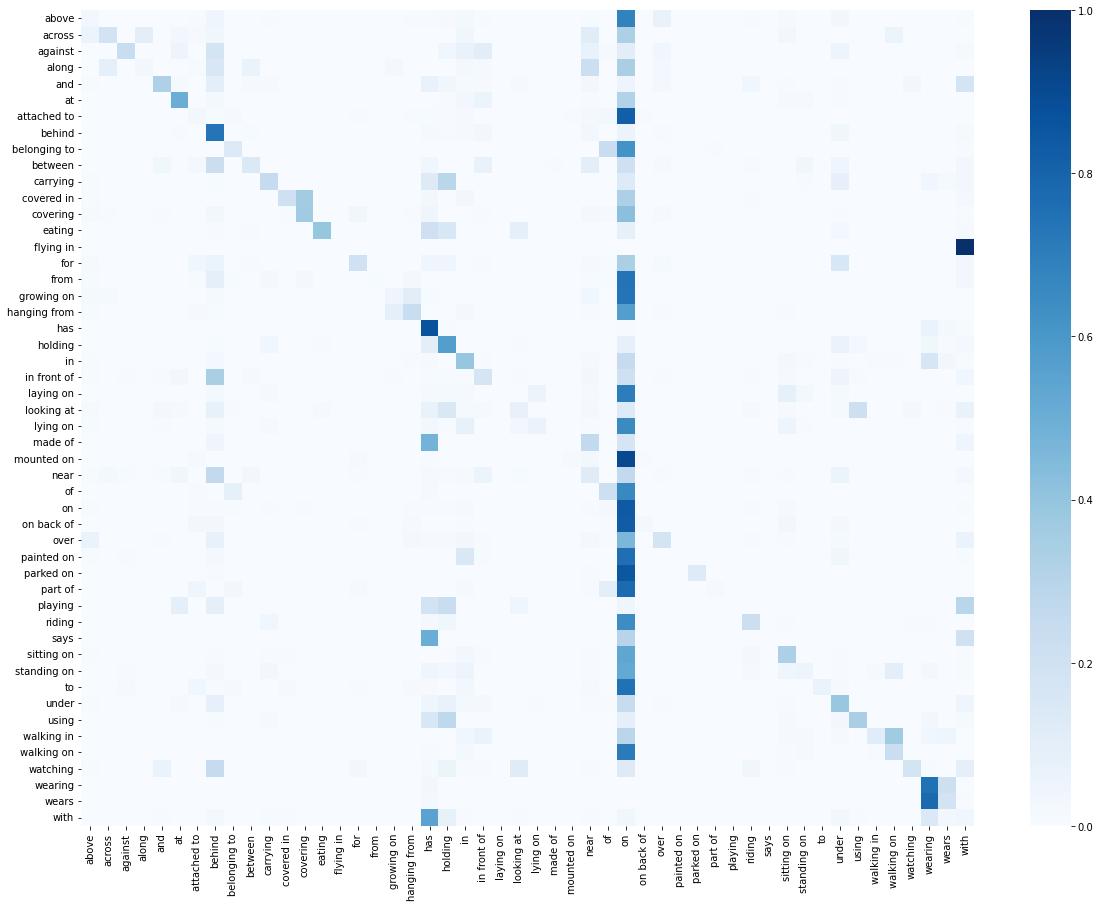

In [420]:
plt.figure(figsize=(20,15))
sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.savefig("/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/analysis/confusion_matrix/kt2cluster-cat-base-motifs-predcls-conf.png", dpi=300)

# Hierarchical Analysis

In [21]:
#find matched pair
pred = []
gt = []
for i in tqdm(range(26446)):
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = tri[2]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels')[:50]
    for j, k in zip(pred_rel_pair, pred_rel_label.tolist()):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = k
        pred_rels.append(tmp)
    selected_pred_label, selected_gt_label = find_match(pred_rels, gt_rels)
    pred = pred+selected_pred_label
    gt = gt+selected_gt_label

100%|██████████| 26446/26446 [00:19<00:00, 1361.56it/s]


In [36]:
json_file = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/datasets/vg/cat-base-3cluster.json"
taxonomy = open(json_file)
taxonomy = json.load(taxonomy)

In [37]:
pars = taxonomy["children"]["root"]
par_dic = {}
for par in pars:
    for ch in taxonomy["children"][par]:
        par_dic[pred2idx[ch]] = par

In [38]:
count = 0
correct = 0
failed_predicate = []
for pre, gr in zip(pred, gt):
    if par_dic[pre]==par_dic[gr]:
        correct += 1
    else:
        failed_predicate.append((idx2pred[str(pre)], idx2pred[str(gr)])) 
    count += 1
print(f"count: {count}")
print(f"Root Accuracy: {correct/count}")

count: 182770
Root Accuracy: 0.915746566723204


In [18]:
# no root KT
failed_cnt = {}
for fail in failed_predicate:
    if fail[1] in failed_cnt.keys():
        failed_cnt[fail[1]] += 1
    else:
        failed_cnt[fail[1]] = 1
print(failed_cnt)

{'near': 2233, 'on': 2011, 'with': 338, 'in': 3115, 'looking at': 73, 'in front of': 276, 'at': 265, 'along': 41, 'behind': 271, 'carrying': 232, 'holding': 679, 'above': 296, 'under': 500, 'over': 228, 'of': 463, 'wearing': 45, 'watching': 55, 'has': 282, 'across': 29, 'painted on': 72, 'attached to': 26, 'for': 132, 'eating': 44, 'using': 43, 'standing on': 118, 'covered in': 99, 'lying on': 5, 'laying on': 11, 'sitting on': 54, 'to': 6, 'from': 80, 'between': 46, 'and': 24, 'riding': 63, 'against': 10, 'wears': 7, 'on back of': 3, 'growing on': 4, 'walking in': 7, 'says': 2, 'playing': 2, 'hanging from': 3, 'made of': 2, 'covering': 17, 'mounted on': 1, 'part of': 0, 'belonging to': 1, 'walking on': 4}


In [25]:
# normal cat-base
failed_cnt = {}
for fail in failed_predicate:
    if fail[1] in failed_cnt.keys():
        failed_cnt[fail[1]] += 1
    else:
        failed_cnt[fail[1]] = 1
print(failed_cnt)

{'in': 2662, 'above': 390, 'near': 2315, 'on': 2333, 'with': 427, 'in front of': 312, 'has': 466, 'at': 242, 'behind': 373, 'carrying': 274, 'holding': 836, 'under': 444, 'over': 216, 'of': 346, 'watching': 41, 'across': 57, 'made of': 6, 'says': 5, 'painted on': 87, 'attached to': 23, 'for': 92, 'eating': 18, 'standing on': 149, 'riding': 147, 'using': 49, 'wearing': 54, 'to': 10, 'along': 46, 'between': 45, 'from': 76, 'looking at': 77, 'sitting on': 97, 'hanging from': 15, 'and': 28, 'on back of': 6, 'parked on': 0, 'wears': 7, 'growing on': 6, 'walking in': 4, 'laying on': 27, 'belonging to': 1, 'against': 11, 'covered in': 6, 'covering': 16, 'mounted on': 1, 'part of': 0, 'playing': 0, 'lying on': 3, 'walking on': 4}


In [399]:
root_mat = confusion_matrix(list(map(lambda x: x[1], failed_predicate)), list(map(lambda x: x[0], failed_predicate)))
mat = copy.deepcopy(root_mat).astype(float)
for i in range(mat.shape[0]):
    if np.sum(mat[i]):
        mat[i] = mat[i]/np.sum(mat[i])

In [400]:
labels = sorted(set(list(map(lambda x: x[1], failed_predicate))+list(map(lambda x: x[0], failed_predicate))))

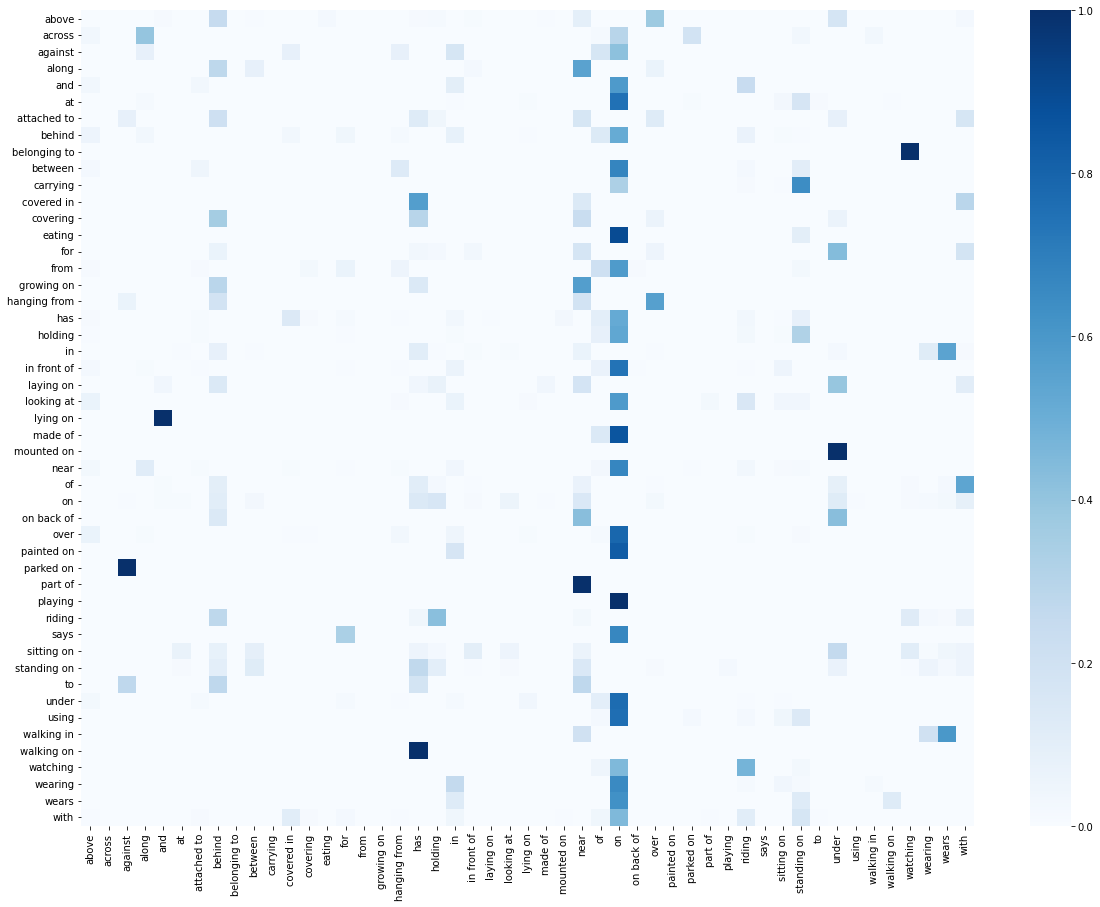

In [402]:
plt.figure(figsize=(20,15))
sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.savefig("/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/analysis/confusion_matrix/kt2cluster-cat-base-motifs-predcls-root-conf.png", dpi=300)

# Group Analysis

In [87]:
group_path = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/datasets/vg/random_group.npy"
G = np.load(group_path, allow_pickle=True).item()
groups = G["groups"]
num_groups = G["num_groups"]
cls2group = -np.ones(51, dtype=int)
for num, group in enumerate(groups):
    for clas in group:
        cls2group[clas] = num

In [88]:
print(cls2group)

[0 7 3 0 1 1 8 5 7 1 1 6 2 6 6 3 8 0 4 8 9 7 7 5 1 0 4 2 3 9 9 9 4 8 0 0 2
 6 8 2 7 5 2 5 3 4 6 1 9 5 7]


In [98]:
def find_match_group(pred_rels, gt_rels, unconstrained=False):
    """
    pred_rels, gt_rels: relation triplets
        sub_label: label of subject (String)
        obj_label: label of object  (String)
        sub_bbox:  bbox of subject  ([num_rel, 4])
        obj_bbox:  bbox of object   ([num_rel, 4])
        rel_label: relation label   (Int) 
        (for pred_rels) candidates: predictions in every group (List)
        (for pred_rels) pred_probs: prediction probability in every group (List)
    """
    selected_pred_label = []
    selected_gt_label = []
    pred_groups = []
    gt_groups = []
    pred_probs = []
    gt_probs = []
    for pre in pred_rels:
        for gt in gt_rels:
            if pre["sub_label"]==gt["sub_label"] and pre["obj_label"]==gt["obj_label"] and bbox_match(pre["sub_bbox"],gt["sub_bbox"] ) and bbox_match(pre["obj_bbox"], gt["obj_bbox"]):
                selected_gt_label.append(gt["rel_label"])
                gt_group = cls2group[gt["rel_label"]]
                gt_groups.append(gt_group)
                gt_probs.append(pre["pred_probs"][gt_group].numpy().tolist())
                selected_pred_label.append(pre["rel_label"])
                pred_group = cls2group[pre["rel_label"]]
                pred_groups.append(pred_group)
                pred_probs.append(pre["pred_probs"][pred_group].numpy().tolist())
                if unconstrained:
                    for num, label in enumerate(pre["candidates"]):
                        if label == gt["rel_label"]:
                            selected_pred_label[-1]=label
                            pred_groups.append(num)
                            pred_probs.append(pre["pred_probs"][num].numpy().tolist())
                
    return selected_pred_label, selected_gt_label, pred_groups, gt_groups, pred_probs, gt_probs

In [101]:
pred = []
gt = []
pred_groups = []
gt_groups = []
pred_distribs = []
gt_distribs = []
for i in tqdm(range(26446)):
# for i in tqdm(range(1)):
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = tri[2]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels')[:50]
    for m, (j, k) in enumerate(zip(pred_rel_pair, pred_rel_label.tolist())):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = k
        tmp["pred_probs"] = []
        tmp["candidates"] = []
        for num in range(num_groups):
            pred_probs = prediction.get_field(f"pred_rel_probs{num}")[m]
            tmp["pred_probs"].append(pred_probs)
            idx = pred_probs.argmax()
            tmp["candidates"].append(groups[num][idx])
        pred_rels.append(tmp)
    selected_pred_label, selected_gt_label, pred_g, gt_g, pred_p, gt_p = find_match_group(pred_rels, gt_rels)
    pred = pred+selected_pred_label
    gt = gt+selected_gt_label
    pred_groups = pred_groups+pred_g
    gt_groups = gt_groups+gt_g
    pred_distribs = pred_distribs+pred_p
    gt_distribs = gt_distribs+gt_p

100%|██████████| 26446/26446 [03:59<00:00, 110.37it/s]


In [102]:
len(gt)==len(pred)

True

In [104]:
len(gt_groups)==len(pred_groups)

True

In [103]:
pred = np.array(pred)
gt = np.array(gt)
len(pred[pred==gt])/len(gt)

0.017786236996685592

In [105]:
val_mat = confusion_matrix(gt_groups, pred_groups)

In [106]:
mat = copy.deepcopy(val_mat).astype(float)
for i in range(mat.shape[0]):
    if np.sum(mat[i]):
        mat[i] = mat[i]/np.sum(mat[i])

In [107]:
labels = np.array([idx2pred[str(i)] for i in set(gt)], dtype=str)

<AxesSubplot:>

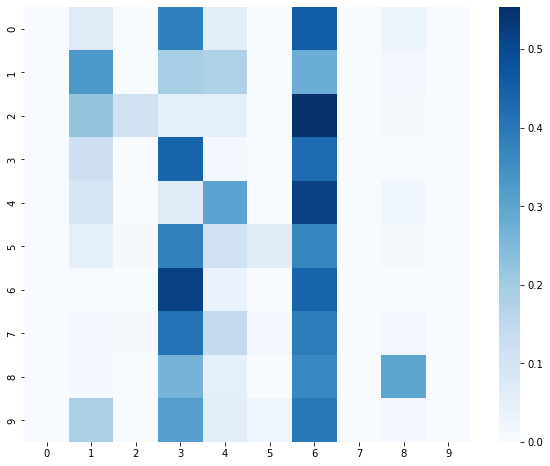

In [111]:
plt.figure(figsize=(10,8))
sns.heatmap(mat, cmap="Blues") # group confusion matrix
# plt.figure(figsize=(20,20))
# sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.savefig("/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/analysis/random-entropy-unconstrained-conf.png", dpi=300)

In [126]:
def vis_distrib(prob, group):
    plt.bar([i+1 for i in range(len(prob))], prob, tick_label=[idx2pred[str(c)] for c in groups[group]])

In [139]:
n = 45

belonging to


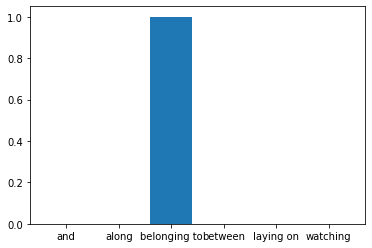

In [140]:
vis_distrib(pred_distribs[n],pred_groups[n])
print(idx2pred[str(pred[n])])

of


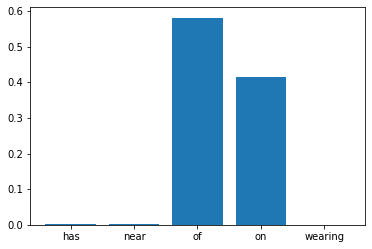

In [141]:
vis_distrib(gt_distribs[n],gt_groups[n])
print(idx2pred[str(gt[n])])